# Introduction
There is a lot of people like to eat avocado and have it in the breakfast with eggs and toasted breads or inside a sushi roll. However, avocado is not cheap!!! This dataset contains information about the price of avocado from 2015 to 2018. Since it is important that we predict the frequency and foresee when it's going to happen, I am going to visualize the data first and build some time series model. Finally, I will forecast the price of avocado.

### Columns:
- Date - the date of the observation
- AveragePrice - the average price of a single avocado
- type - conventional or organic
- year - the year of observation that was collected
- Region - the city or region of the observation
- Total Volume - Total number of avocados sold
- 4046 - Total number of avocados with PLU 4046 sold
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold

In [1]:
import requests
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import io
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse
import seaborn as sns

#to make the decompose plot bigger
from matplotlib import pylab
from pylab import *

#decompose the dataset
from pylab import rcParams

# Fit the ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

from pandas import read_csv
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('avocado.csv')

It is important that we use a datetime data type for the date, so I will covert 'date' data type to datetime.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df['Date'].head()

0   2015-12-27
1   2015-12-20
2   2015-12-13
3   2015-12-06
4   2015-11-29
Name: Date, dtype: datetime64[ns]

In [5]:
df['Date'].tail()

18244   2018-02-04
18245   2018-01-28
18246   2018-01-21
18247   2018-01-14
18248   2018-01-07
Name: Date, dtype: datetime64[ns]

In [6]:
df['Date'].min()

Timestamp('2015-01-04 00:00:00')

In [7]:
df.shape

(18249, 14)

In [8]:
df.isnull().values.any()

False

In [9]:
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

### Exploratory Data Analysis

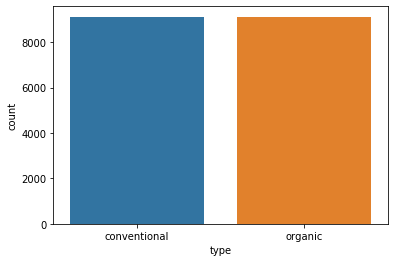

In [10]:
ax = sns.countplot('type',data=df)

In [11]:
df[['region','type']].describe()

,region,type
count,18249,18249
unique,54,2
top,NorthernNewEngland,conventional
freq,338,9126


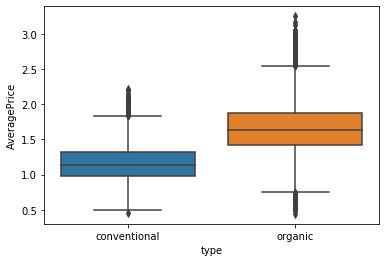

In [12]:
sns.boxplot(data=df, x='type', y='AveragePrice')

According to the boxplot above, there are two different types of avocado included in this dataset. I am only interested in the organic avocado because it is healthier. Starting from here, I will only look at the average price of the organic avocado.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


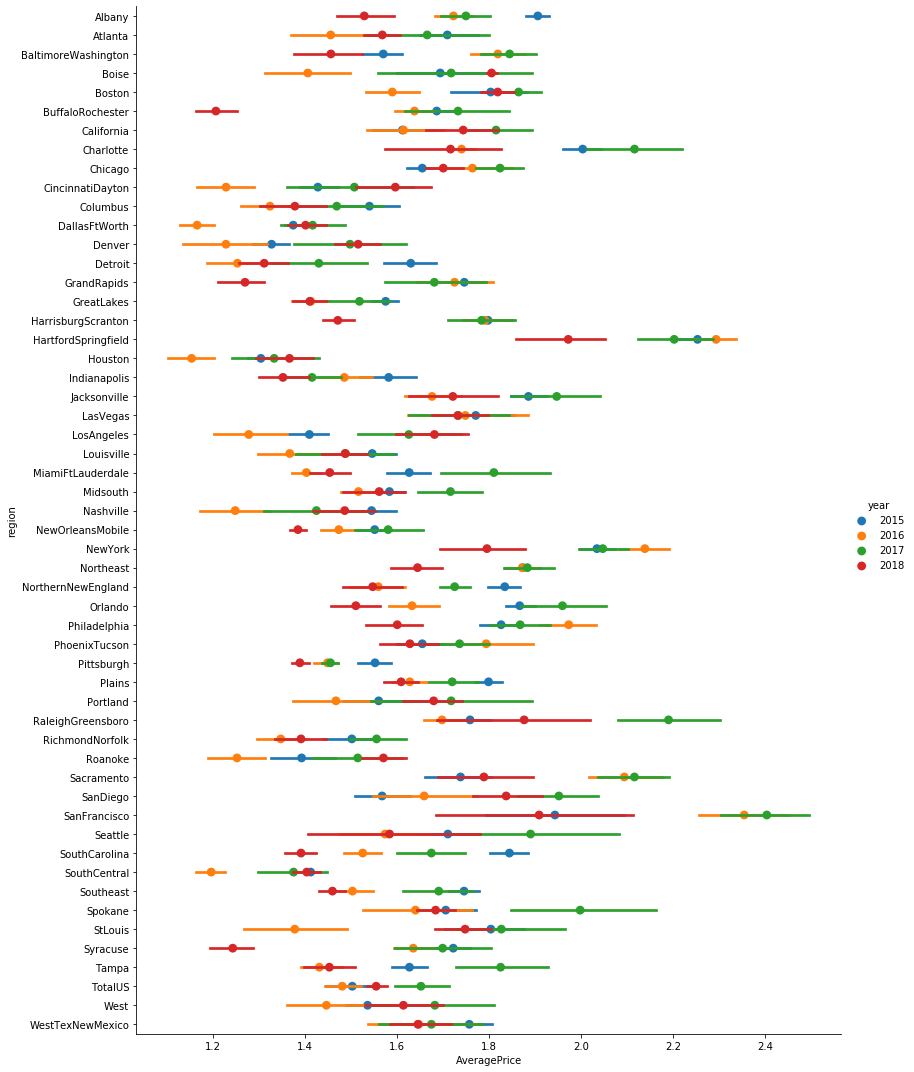

In [13]:
organic = df['type'] == 'organic'
o = sns.factorplot('AveragePrice','region',data=df[organic],hue='year',
                  size=15,aspect=0.8,join=False)

According to the factorplot above, we can see that each color represents different year. If we see a dot located on the very right hand side, that means the organic avocado in this region is expensive. For example, the average price of the organic avocado in San Francisco is about 2 USD in 2018. That tells us maybe try not to eat a lot of avocado when you are in San Francisco. The places that have cheap organic avocados include Sycracuse, which is located in New York.

In [14]:
# split out the organic type
o = df.loc[df['type'] == 'organic']

In [15]:
# check missing values
o.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [16]:
o.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
9126,0,2015-12-27,1.83,989.55,8.16,88.59,0.0,892.80,892.80,0.00,0.0,organic,2015,Albany
9127,1,2015-12-20,1.89,1163.03,30.24,172.14,0.0,960.65,960.65,0.00,0.0,organic,2015,Albany
9128,2,2015-12-13,1.85,995.96,10.44,178.70,0.0,806.82,806.82,0.00,0.0,organic,2015,Albany
9129,3,2015-12-06,1.84,1158.42,90.29,104.18,0.0,963.95,948.52,15.43,0.0,organic,2015,Albany
9130,4,2015-11-29,1.94,831.69,0.00,94.73,0.0,736.96,736.96,0.00,0.0,organic,2015,Albany


In [17]:
o = o.set_index('Date')
o

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-12-27,0,1.83,989.55,8.16,88.59,0.00,892.80,892.80,0.00,0.0,organic,2015,Albany
2015-12-20,1,1.89,1163.03,30.24,172.14,0.00,960.65,960.65,0.00,0.0,organic,2015,Albany
2015-12-13,2,1.85,995.96,10.44,178.70,0.00,806.82,806.82,0.00,0.0,organic,2015,Albany
2015-12-06,3,1.84,1158.42,90.29,104.18,0.00,963.95,948.52,15.43,0.0,organic,2015,Albany
2015-11-29,4,1.94,831.69,0.00,94.73,0.00,736.96,736.96,0.00,0.0,organic,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-04,7,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
2018-01-28,8,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
2018-01-21,9,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico


In [18]:
organic = o.groupby('Date')['AveragePrice'].sum().reset_index()

In [19]:
organic = organic.set_index('Date')
organic.index

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08',
               ...
               '2018-01-21', '2018-01-28', '2018-02-04', '2018-02-11',
               '2018-02-18', '2018-02-25', '2018-03-04', '2018-03-11',
               '2018-03-18', '2018-03-25'],
              dtype='datetime64[ns]', name='Date', length=169, freq=None)

In [20]:
# average price of organic avocado in each month
y = organic['AveragePrice'].resample('MS').mean()

In [21]:
y['2016':'2017'].head()

Date
2016-01-01    80.7000
2016-02-01    82.9925
2016-03-01    78.1450
2016-04-01    78.2425
2016-05-01    79.0140
Freq: MS, Name: AveragePrice, dtype: float64

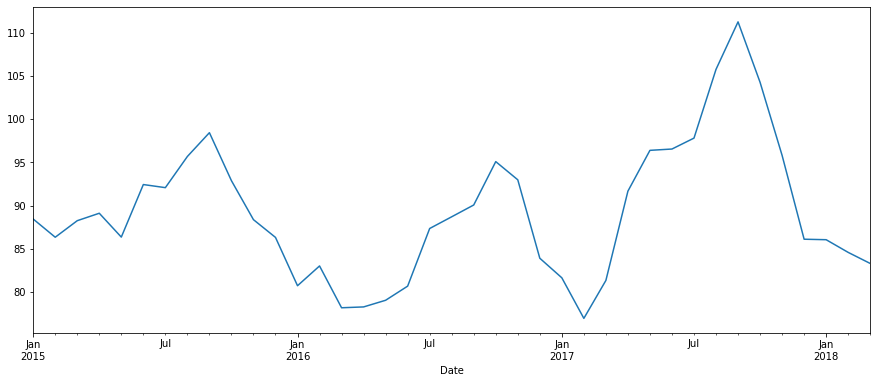

In [22]:
y.plot(figsize=(15, 6))
plt.show()

### Decompose the Dataset
I decomposed the data of organic avocado average price into observed, trend, seasonal, and residual. According to the seasonal plot, looks like the organic avocado will reach the highest price right before the end of each year. I can't tell anything from the trend since there is no upward or downward trend. The observed and residual plots are near normally distributed.

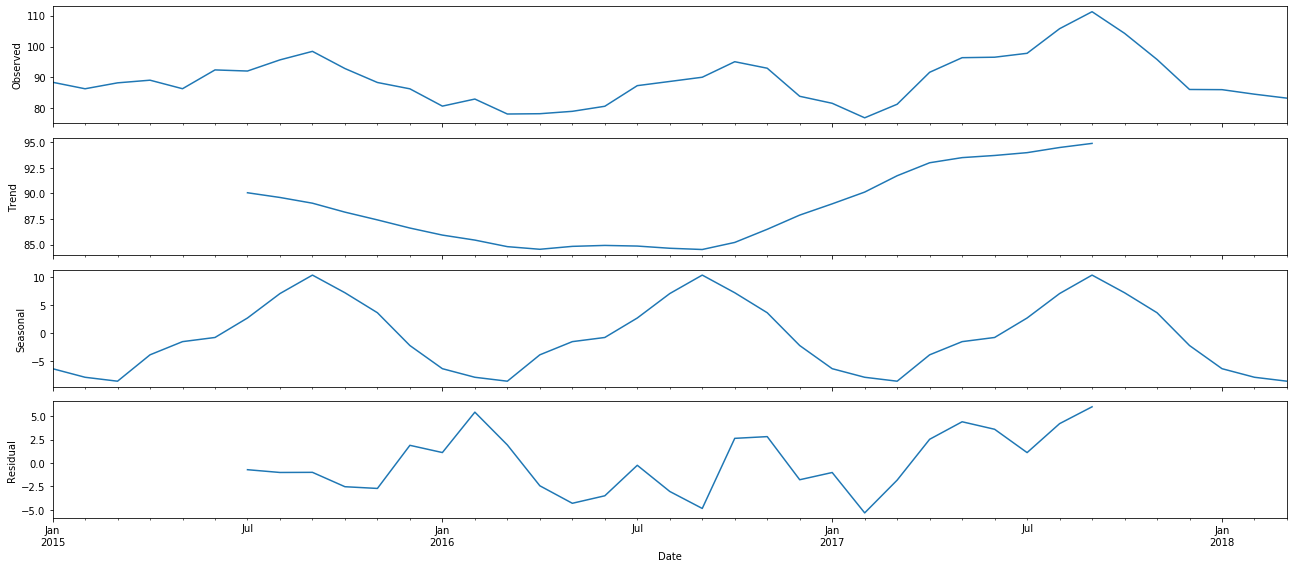

In [23]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Is the data stationary?
Null Hypothesis H0: the present of unit root; data is not stationary          
Alternate Hypothesis H1: data is stationary 

In [24]:
# ADF Test 
adf_result= adfuller(df.AveragePrice.tolist()) 
print('ADF Statistic: %f' % adf_result[0]) 
print('p-value: %f' % adf_result[1]) 

ADF Statistic: -7.449624
p-value: 0.000000


In [25]:
series = read_csv('avocado.csv', header=0, index_col=0, squeeze=True)
X = series['AveragePrice']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.449624
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


If test statistics is less than critical values: reject H0; otherwise, accept H0.     
- 99% confidence interval: data is stationary       
- 95% confidence interval: data is stationary     
- 90% confidence interval: data is stationary

If the p-value is less than 0.05, the data is stationary.
- In this case, the p-value is 0, this data is stationary


# Data Analysis: Part I

### ARIMA

In [26]:
df.head(1)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany


In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The Step above is to help use identify what are the parameters we can use to build a good model. Our goal is to use the parameters from below to get the best performance for the model. I will use different parameters and run the results and make a comparison.

In [28]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

a = "bob"
b = "bob"
c = 1.0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #Only for diagnostic measures
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                  #param_seasonal, results.aic))
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue

In [29]:
model_output.sort_values(by = 'results.aic').head()

,parameters,results.aic
41,"ARIMA(1, 1, 0)x(1, 1, 0, 12)12",83.357443
47,"ARIMA(1, 1, 1)x(1, 1, 0, 12)12",83.945311
17,"ARIMA(0, 1, 0)x(1, 1, 0, 12)12",87.785924
23,"ARIMA(0, 1, 1)x(1, 1, 0, 12)12",87.878781
35,"ARIMA(1, 0, 1)x(1, 1, 0, 12)12",87.914450


The optimal option is the one that has the lowest AIC. According to he output above, ARIMA(1, 1, 0)x(1, 1, 0, 12) has the lowest AIC and ARIMA(1, 0, 1)x(1, 1, 0, 12) has the highest AIC. I will run a model of these two and make a comparison.

### Fitting the ARIMA model
- optimal option 1: ARIMA(1, 1, 0)x(1, 1, 0, 12)
- optimal option 2: ARIMA(1, 0, 1)x(1, 1, 0, 12)

#### optimal option 1: ARIMA(1, 1, 0)x(1, 1, 0, 12) - Lowest AIC
This is a first-order autoregressive model. 

In [30]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod.fit()
print(results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2504      0.271      0.922      0.356      -0.282       0.782
ar.S.L12      -0.6362      0.231     -2.759      0.006      -1.088      -0.184
sigma2        22.4815     14.552      1.545      0.122      -6.040      51.004


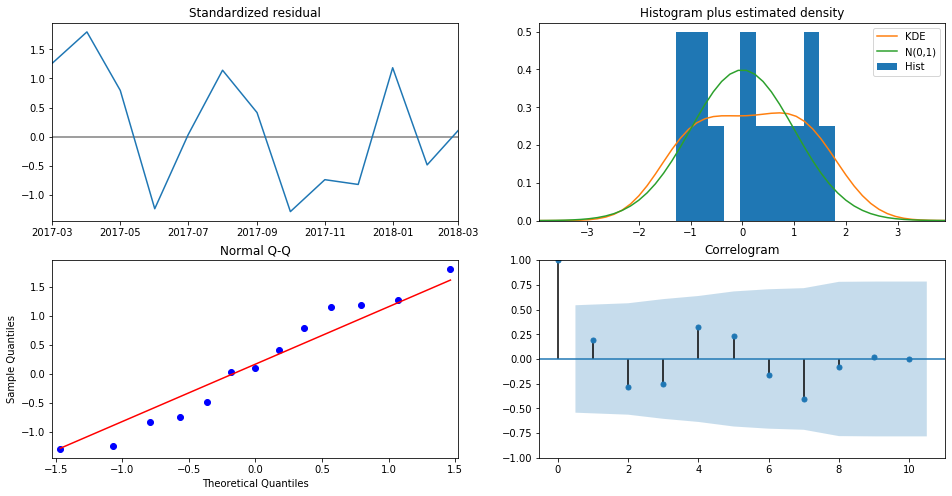

In [31]:
results1.plot_diagnostics(figsize=(16, 8))
plt.show()

- The model residuals are near normally distributed.
- From the Normal Q-Q plot, the line fits the dots very well and we can clearly see an upward trend.

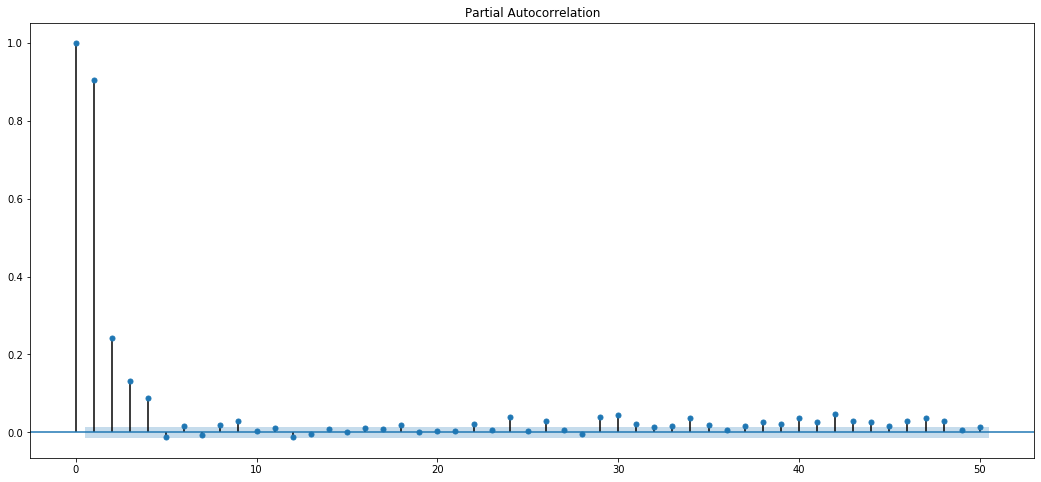

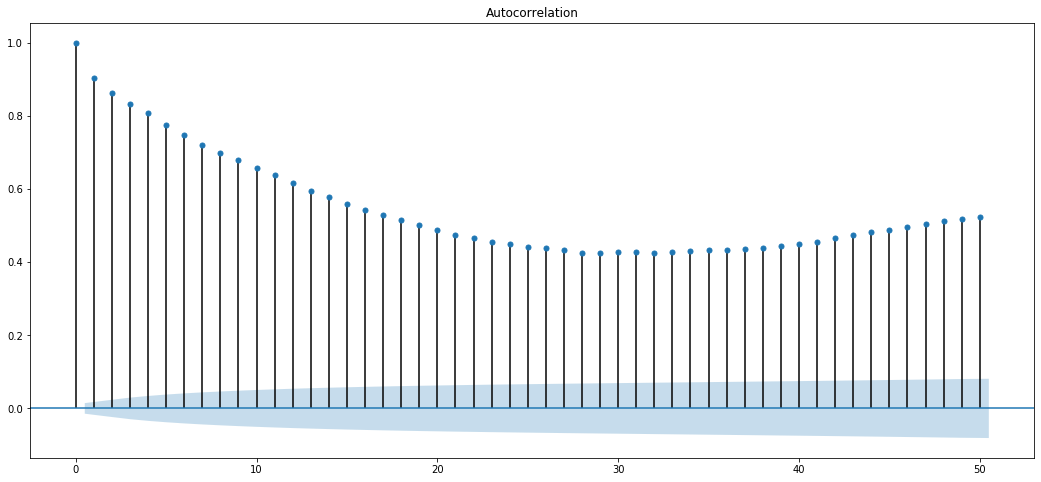

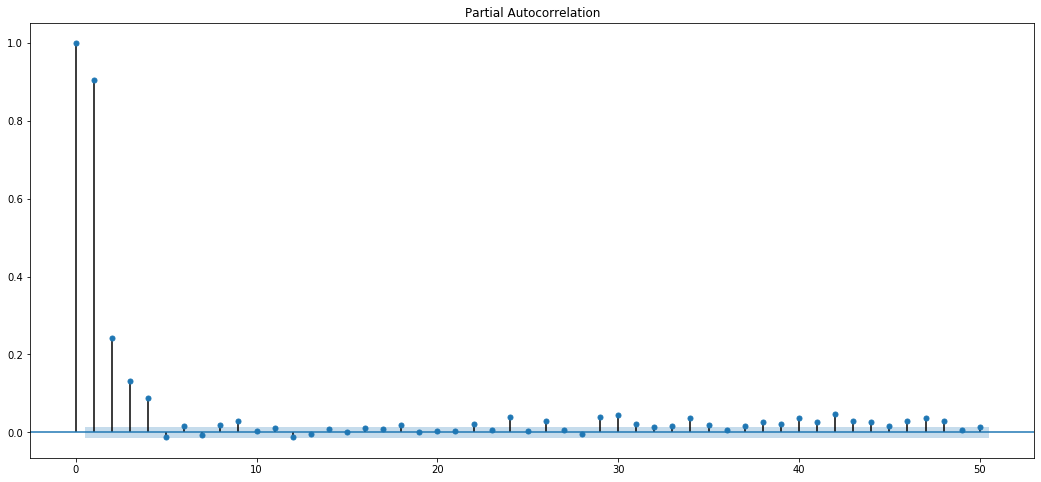

In [32]:
df['residual']=df['AveragePrice']-df['AveragePrice'].mean() 
plot_acf(df.residual, lags=50) 
plot_pacf(df.residual, lags=50)

## Validating Forecasts

In [33]:
pred = results1.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

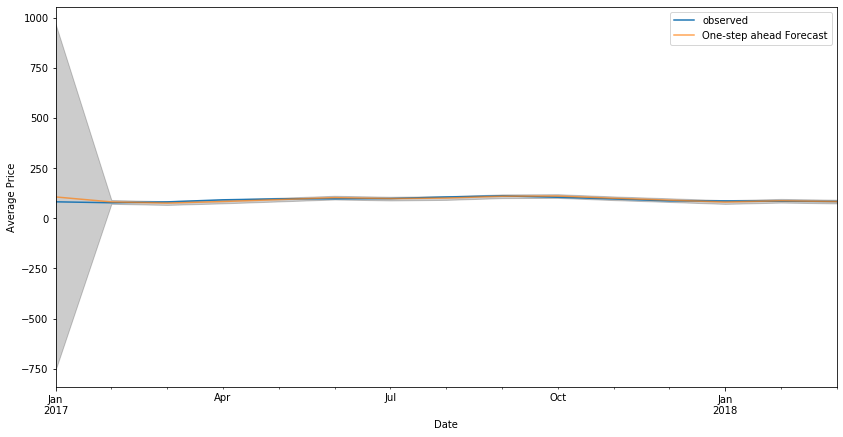

In [34]:

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()

In [35]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 59.97


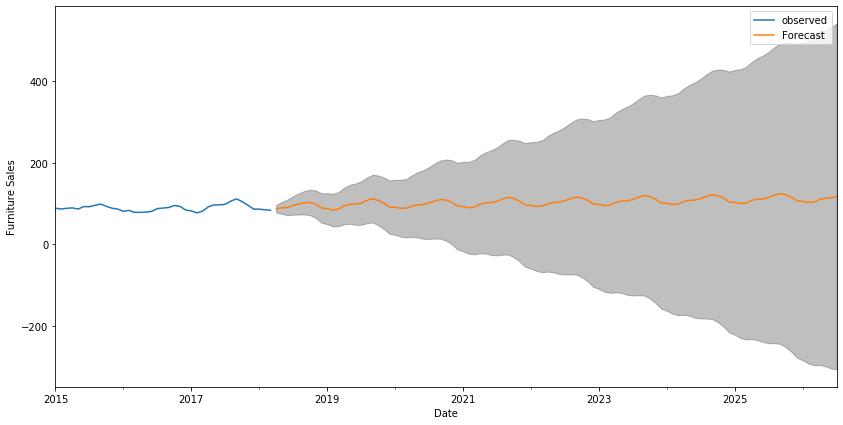

In [36]:
pred_uc = results1.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

#### Forecasting Inferences

To help us better understand the model performance, I compared the predicted average price to the real average price from 2017 to the end of the data. The MSE is 59.97. We can tell from the plot above that the observed and forecast lines are about the same.

Also, I don't see any upward or downward trend. That means the average price of the organic avocado in the next year will be about the same as the previous year unless something unexpected is going to happen.



# Data Analysis Part 2
### Re-run the model with the optimal option 2 parameters
- optimal option 2: ARIMA(1, 0, 1)x(1, 1, 0, 12) - highest AIC

In [37]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7196      0.274      2.631      0.009       0.183       1.256
ma.L1          0.5447      0.442      1.232      0.218      -0.322       1.411
ar.S.L12      -0.5380      0.243     -2.215      0.027      -1.014      -0.062
sigma2        17.3406     15.014      1.155      0.248     -12.086      46.767


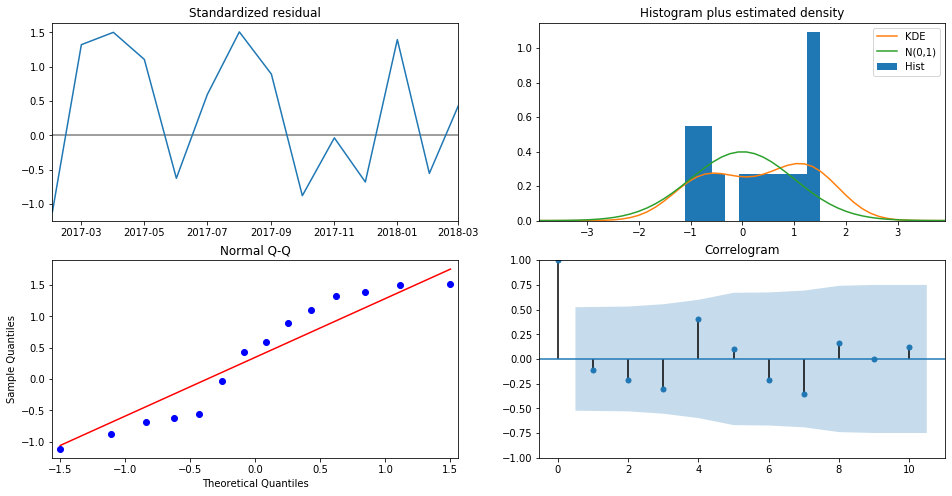

In [38]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

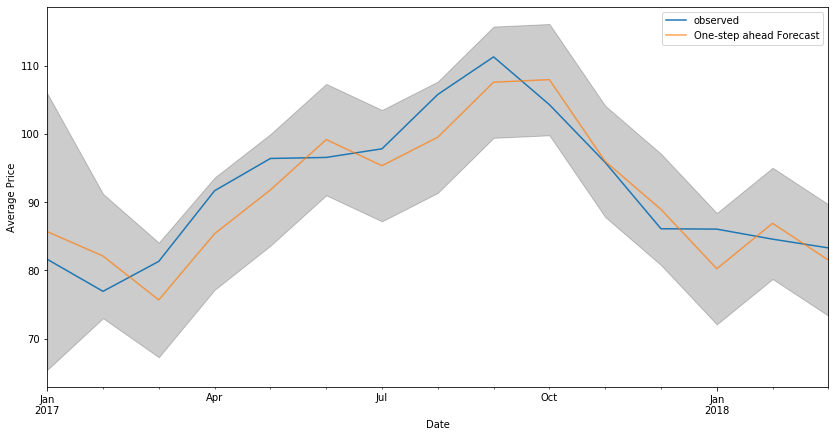

In [40]:

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()

In [41]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 17.74


## Forecasting
- Extend the date to January 2020

The two plots below clearly shows the forecasts of the model until 2020. We can clearly see the seasonality of organic avocado average price from the plot below. Looks like the seasonality is almost the same for each year with the highest price near the end of each year.

However, the optimal option 2 plot is outfitting. The forecasted average price of each year from 2019 to 2022 is too good to be true because the forecasts of each year after 2018 is about the same. However, if I extend the data to the very far into the future, the confidence of getting an accurate prediction should go down. In this case, the prediction of each year is about the same and the MSE is small too. Therefore, I will still use the optimal option 1 parameter to forecast the average price of the organic avocado.

#### Using optimal option 1 result

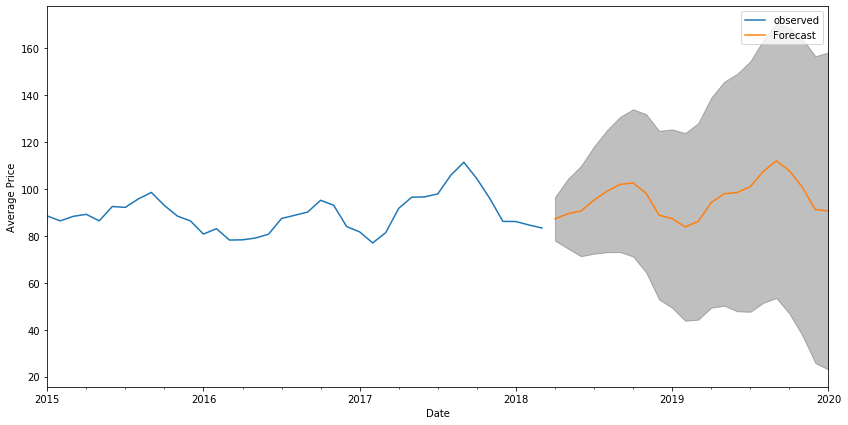

In [42]:

pred_uc = results1.get_forecast(steps=22)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()

In [43]:
print(results1.forecast(22))

2018-04-01     87.160620
2018-05-01     89.385111
2018-06-01     90.486228
2018-07-01     95.198738
2018-08-01     98.961920
2018-09-01    101.835454
2018-10-01    102.486653
2018-11-01     98.063114
2018-12-01     88.742171
2019-01-01     87.277500
2019-02-01     83.750550
2019-03-01     86.081868
2019-04-01     94.078583
2019-05-01     97.897804
2019-06-01     98.395377
2019-07-01    100.915413
2019-08-01    107.354168
2019-09-01    111.903525
2019-10-01    107.684214
2019-11-01    100.683946
2019-12-01     91.108790
2020-01-01     90.539729
Freq: MS, dtype: float64


#### Using optimal option 2 result

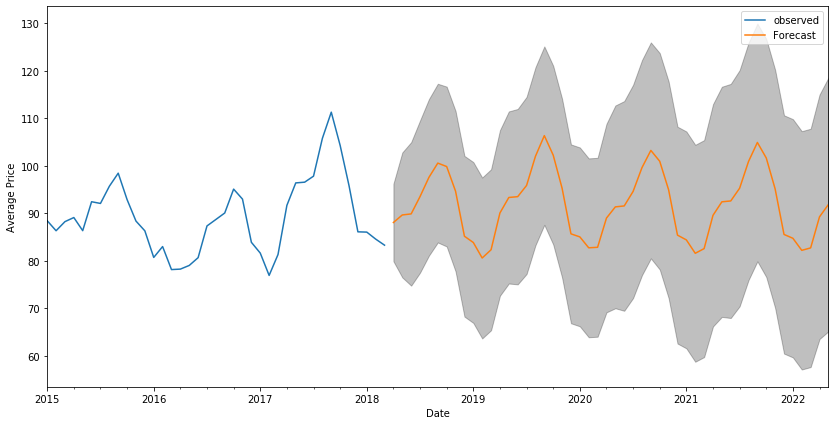

In [44]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()

In [45]:
print(results.forecast(22))

2018-04-01     88.058429
2018-05-01     89.645379
2018-06-01     89.867863
2018-07-01     93.522770
2018-08-01     97.557228
2018-09-01    100.565509
2018-10-01     99.839314
2018-11-01     94.649798
2018-12-01     85.165883
2019-01-01     83.845633
2019-02-01     80.583777
2019-03-01     82.319467
2019-04-01     90.067985
2019-05-01     93.326941
2019-06-01     93.497709
2019-07-01     95.857493
2019-08-01    102.001248
2019-09-01    106.348910
2019-10-01    102.241381
2019-11-01     95.282315
2019-12-01     85.669160
2020-01-01     85.027155
Freq: MS, dtype: float64


# Key Takeaways:
- The monthly average price of all the organic avocado won't go higher than 107 USD
- For the optimal option 2: the forecasting performance I got by using the highest AIC and lowest MSE parameters is out-fitting. The average price prediction until 2022 is too good to be true.
- By looking at the optimal option 1 forecasting plot, the predicted average price after 2018 is approximately the same as the average price before 2018. There is no any significant increases in price after 2018.
- The most important thing is that don't worry about the avocado price will have a big increase in the future. If you can afford it now, it is very likely you will still be able to afford it in the future, at least until 2020.